# Fishing Effort Globally

In [24]:
from math import radians, cos, sin, asin, sqrt
import matplotlib
%matplotlib inline
from matplotlib import colors,colorbar
from matplotlib.patches import PathPatch,Polygon
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from numpy import asarray, concatenate, ones
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.ops import transform
import bq  
import csv 
import fiona
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import time
import math

client = bq.Client.Get()

In [21]:
# create a bounding box:
max_lat = 85
min_lat = -80
max_lon = 180
min_lon = -180
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

def get_area(lat):
    lat_degree = 69 # miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+cellsize/2.)*degrees_to_radians #plus half a cell size to get the middle
    lon_degree = math.cos(phi)*lat_degree 
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 # miles to square km

In [15]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [63]:
def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)

def to_round(num):
    if num < 1:
        return num
    else:
        return int(num)
    for i in range(10,-1,-1):
        if 10**-i > num >10**-(i+1):
            break
    if i == 0:
        if num < 1:
            return round(num,1)
        return int(round(num,0))
    return round(num,i+1)

In [65]:
to_round(2.1)
to_round(.001)

0.001

In [68]:
def makeMap(grid,fig_title,fig_min_value,fig_max_value,colormap='vidris'):
    fig = plt.figure(figsize=(12, 8)) 
    
    firstlat = max_lat
    lastlat =  min_lat
    firstlon = min_lon
    lastlon = max_lon
    scale = cellsize

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    extra = 0
    m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
              llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

    m.drawmapboundary()#fill_color='#111111')
#     m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

    x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = fig_max_value # grid.max()
    minimum = fig_min_value #1

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap(colormap))

    t = fig_title
    plt.title(t, color = "#000000", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=6)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap(colormap))

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    
    cb.ax.set_xticklabels([to_round(i) for i in lvls], fontsize=10, color = "#000000")
    cb.set_label(r'Fishing Hours per km$^2$',labelpad=-40, y=0.45, color = "#000000")
    plt.savefig(fig_title+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
    plt.show()

In [17]:
# All fishing in the world
q = '''
SELECT
  INTEGER(floor(lat*4)) lat_bin,
  INTEGER(floor(lon*4)) lon_bin,
  SUM(hours) hours
FROM
  (select lat, lon, hours, measure_new_score, seg_id, eez, mmsi from
  TABLE_DATE_RANGE([pipeline_classify_logistic_715_fishing.], TIMESTAMP("2015-01-01"), TIMESTAMP("2015-12-31"))
WHERE
       lat > '''+str(min_lat)+'''
       AND lat <'''+str(max_lat)+'''
       AND lon > '''+str(min_lon)+'''
       AND lon < '''+str(max_lon)+'''
       and measure_new_score > .5) 
       where 
       seg_id NOT IN ( // eliminate clearly bad segments
  SELECT
    seg_id
  FROM
    [scratch_david_seg_analysis_715.2015_segments]
  WHERE
    (point_count<20
      AND terrestrial_positions = point_count)
    OR ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225) ))
      and mmsi not in (412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093,412211691,
      412420276,412420917,411041815, 525018188, 412420276,412420561,533180156)
GROUP BY
  lat_bin,
  lon_bin
'''


Waiting on bqjob_r6061afd6959e3383_00000156524cc5f7_2 ... (37s) Current status: DONE   
Query time: 74.9342179298 seconds.


In [25]:
# print q
fishing_grid_all = Query(q)

grid_all = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid_all:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid_all[lat_index][lon_index] = float(row[2])/get_area(lat*cellsize) # divides by area in square km

Waiting on bqjob_r417bfea3c00def1d_0000015652595c77_5 ... (0s) Current status: DONE   
Query time: 21.531167984 seconds.


In [18]:
'''Make a custom colormap'''

tm = 255
thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#620110',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


thecolors = [['#FDD0BD',0,0], # a small vaiation on 'Reds' colormap
          ['#62000C',255,255]]
cdict = { 'red':tuple(   (color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in thecolors ),
      'green':tuple( (color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in thecolors ),
      'blue':tuple(  (color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in thecolors )}

mycmap_redder = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)


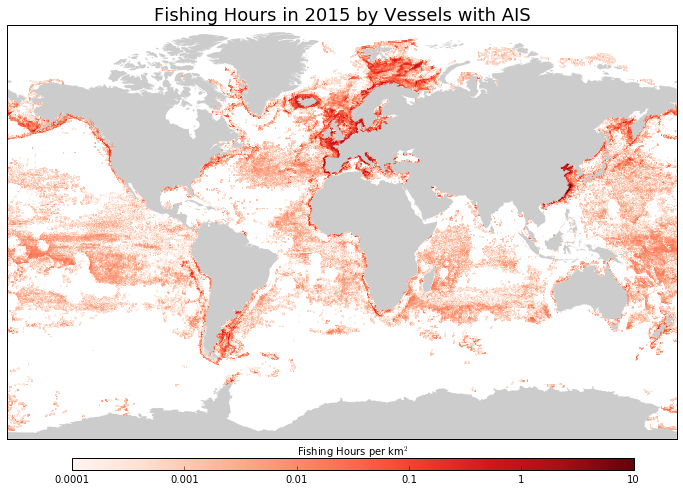

In [69]:
makeMap(grid_all,"Fishing Hours in 2015 by Vessels with AIS",.0001,10, colormap="Reds")